In [31]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import seaborn as sns
import glob
from pathlib import Path
torch.manual_seed(1)
np.random.seed(1)

# $env:PYTORCH_CUDA_ALLOC_CONF = "max_split_size_mb=8192"


In [32]:
training_path = 'C:\\Users\\jrura\\Desktop\\biai_resources\\datasets\\small\\asl\\asl_alphabet_train\\asl_alphabet_train'
testing_path = 'C:\\Users\\jrura\\Desktop\\biai_resources\\datasets\\small\\asl\\asl_alphabet_test\\asl_alphabet_test'
classes = os.listdir(training_path)
train_images = []
train_labels = []
test_labels = []
test_images = []

for cl in classes:
    files = os.listdir(training_path + '/' + cl)
    for file in files:
        file_path = os.path.join(training_path, cl, file)
        train_images.append(file_path) # add path to image
        # maybe check if file is image
        train_labels.append(cl) # add label

test_file_list = os.listdir(testing_path)
for file in test_file_list:
    file_path = os.path.join(testing_path, file)
    test_images.append(file_path)
    test_labels.append(file.split('_')[0]) # add label to test image





In [33]:
from os import name


train_images = pd.Series(train_images, name= 'image_paths')
train_labels = pd.Series(train_labels, name='labels')

test_images = pd.Series(test_images, name= 'image_paths')
test_labels = pd.Series(test_labels, name='labels')

train_dataFrame = pd.DataFrame(pd.concat([train_images, train_labels], axis=1))
test_dataFrame = pd.DataFrame(pd.concat([test_images, test_labels], axis=1))
train_dataFrame
test_dataFrame

,image_paths,labels
0,C:\Users\jrura\Desktop\biai_resources\datasets...,A
1,C:\Users\jrura\Desktop\biai_resources\datasets...,B
2,C:\Users\jrura\Desktop\biai_resources\datasets...,C
3,C:\Users\jrura\Desktop\biai_resources\datasets...,D
4,C:\Users\jrura\Desktop\biai_resources\datasets...,E
5,C:\Users\jrura\Desktop\biai_resources\datasets...,F
6,C:\Users\jrura\Desktop\biai_resources\datasets...,G
7,C:\Users\jrura\Desktop\biai_resources\datasets...,H
8,C:\Users\jrura\Desktop\biai_resources\datasets...,I
9,C:\Users\jrura\Desktop\biai_resources\datasets...,J


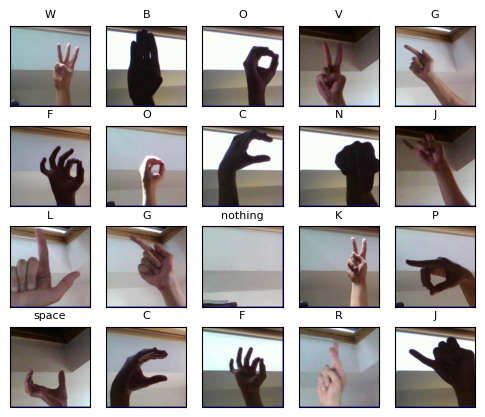

In [34]:
plt.figure (figsize = (6,5))

for i in range(20): # show 20 images
    index = np.random.randint(0, len(train_dataFrame) - 1)
    plt.subplot(4, 5, i + 1)
    img = train_dataFrame.iloc[index, 0]
    plt.imshow(plt.imread(img))
    plt.title(train_dataFrame.iloc[index, 1], size=8, color='black')
    plt.xticks([])
    plt.yticks([])

plt.show()

In [35]:
train_dataFrame, validation_df = train_test_split(train_dataFrame, train_size=0.8, random_state=0)
print(train_dataFrame['labels'].value_counts())
print(validation_df['labels'].value_counts())
print(test_dataFrame['labels'].value_counts())

Y          2732
T          2732
N          2726
D          2719
U          2719
A          2710
V          2710
nothing    2709
L          2706
X          2705
E          2704
J          2704
C          2704
W          2704
G          2703
del        2699
H          2697
P          2696
B          2696
R          2692
O          2691
K          2686
M          2684
I          2683
space      2681
F          2680
S          2678
Z          2676
Q          2674
Name: labels, dtype: int64
Q          326
Z          324
S          322
F          320
space      319
I          317
M          316
K          314
O          309
R          308
B          304
P          304
H          303
del        301
G          297
J          296
W          296
E          296
C          296
X          295
L          294
nothing    291
V          290
A          290
D          281
U          281
N          274
T          268
Y          268
Name: labels, dtype: int64
A          1
B          1
Y          1
X       

f

In [36]:
labelEnc = LabelEncoder()
train_dataFrame['encoded_labels'] = labelEnc.fit_transform(train_dataFrame['labels'])
validation_df['encoded_labels'] = labelEnc.transform(validation_df['labels'])
test_dataFrame['encoded_labels'] = labelEnc.transform(test_dataFrame['labels'])
train_dataFrame.head()


,image_paths,labels,encoded_labels
38857,C:\Users\jrura\Desktop\biai_resources\datasets...,L,11
69213,C:\Users\jrura\Desktop\biai_resources\datasets...,U,20
8425,C:\Users\jrura\Desktop\biai_resources\datasets...,C,2
44934,C:\Users\jrura\Desktop\biai_resources\datasets...,N,13
20329,C:\Users\jrura\Desktop\biai_resources\datasets...,F,5


In [37]:
class ASLDataset(torch.utils.data.Dataset):
    def __init__(self, dataFrame, transform=transforms.Compose([transforms.ToTensor()])):
        self.dataFrame = dataFrame
        self.transform = transform
    
    def __len__(self):
        length = len(self.dataFrame)
        return length
    
    def __getitem__(self, index):
        image_path = self.dataFrame.iloc[index, 0]
        label = self.dataFrame.iloc[index, 2]
        label = torch.tensor(label)
        image = Image.open(image_path).convert('RGB')
        img = np.array(image)
        image = self.transform(image=img)['image']
        return image, label

In [38]:
train_transforms = A.Compose([
    A.GaussNoise(p=0.5),
    A.Blur(p=0.5),
     # resize image to 100x100
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),
    ToTensorV2()
])  

test_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224,0.225]),
    ToTensorV2()
])

In [39]:
train_dataset = ASLDataset(train_dataFrame, transform=train_transforms)
validation_dataset = ASLDataset(validation_df, transform=test_transforms)
test_dataset = ASLDataset(test_dataFrame, transform=test_transforms)

test_dataFrame

,image_paths,labels,encoded_labels
0,C:\Users\jrura\Desktop\biai_resources\datasets...,A,0
1,C:\Users\jrura\Desktop\biai_resources\datasets...,B,1
2,C:\Users\jrura\Desktop\biai_resources\datasets...,C,2
3,C:\Users\jrura\Desktop\biai_resources\datasets...,D,3
4,C:\Users\jrura\Desktop\biai_resources\datasets...,E,4
5,C:\Users\jrura\Desktop\biai_resources\datasets...,F,5
6,C:\Users\jrura\Desktop\biai_resources\datasets...,G,6
7,C:\Users\jrura\Desktop\biai_resources\datasets...,H,7
8,C:\Users\jrura\Desktop\biai_resources\datasets...,I,8
9,C:\Users\jrura\Desktop\biai_resources\datasets...,J,9


In [40]:
batch_size = 128 # 32 images per batch

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size) # shuffle data
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()

cuda


# CNN Model


In [42]:
# class SignLanguageNet(nn.Module):
#     def __init__(self, num_classes=26):
#         super(SignLanguageNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(256 * 28 * 28, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x


class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Sequential(
            nn.Linear(32 * 100 * 100, 81),
            nn.Dropout(0.2),
            nn.BatchNorm1d(81),
            nn.LeakyReLU(81, 29))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 32 * 100 * 100)
        x = self.fc(x)
        return x

In [43]:
class EarlyStop:
    
    # stops when valid loss doesn't improve for patience number of epochs
    def __init__(self, patience=5, verbose=True, delta=0):
        # patience is number of epochs to wait before stopping when loss doesn't improve
        # verbose is whether to print out epoch logs
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf # set initial "min" to infinity

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            

In [48]:
model = SimpleCNN()


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=3, cooldown=2,  verbose=True)


model = model.to(device)
criterion = criterion.to(device)


In [45]:
epochs = 20

total_train_loss = []
total_valid_loss = []
best_valid_loss = np.Inf
early_stop = EarlyStop(patience=5, verbose=True)

for epoch in range(epochs):
    print('Epoch:', epoch + 1)
    train_loss = []
    valid_loss = []
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0
    for image, target in train_loader:
        model.train()
        image, target = image.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, target.to(torch.long))  # Convert target labels to torch.long
        train_loss.append(loss.item())
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
        
        loss.backward()
        optimizer.step()
        
    for image, target in validation_loader:
        with torch.no_grad():
            model.eval()
            image, target = image.to(device), target.to(device)
            
            output = model(image)
            loss = criterion(output, target.to(torch.long))  # Convert target labels to torch.long
            valid_loss.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            valid_total += target.size(0)
            valid_correct += (predicted == target).sum().item()
            
    epoch_train_loss = np.mean(train_loss)
    epoch_valid_loss = np.mean(valid_loss)
    print(f'Epoch {epoch + 1}, training loss: {epoch_train_loss:.4f}, validation loss: {epoch_valid_loss:.4f}, training accuracy: {(100 * train_correct / train_total):.4f}%, validation accuracy: {(100 * valid_correct / valid_total):.4f}%')
    
    if epoch_valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'asl_model_giga.pt')
        print('Model improved. Saving model.')
        best_valid_loss = epoch_valid_loss
    
    early_stop(epoch_valid_loss, model)
        
    if early_stop.early_stop:
        print("Early stopping")
        break
        
    lr_scheduler.step(epoch_valid_loss)
    total_train_loss.append(epoch_train_loss)
    total_valid_loss.append(epoch_valid_loss)


Epoch: 1
Epoch 1, training loss: 5.9254, validation loss: 2.5237, training accuracy: 10.4955%, validation accuracy: 28.0345%
Model improved. Saving model.
Epoch: 2
Epoch 2, training loss: 2.5244, validation loss: 2.2584, training accuracy: 25.8212%, validation accuracy: 31.3218%
Model improved. Saving model.
Epoch: 3
Epoch 3, training loss: 2.2528, validation loss: 1.8809, training accuracy: 37.1865%, validation accuracy: 50.7701%
Model improved. Saving model.
Epoch: 4
Epoch 4, training loss: 2.0575, validation loss: 1.7691, training accuracy: 44.2350%, validation accuracy: 53.9885%
Model improved. Saving model.
Epoch: 5
Epoch 5, training loss: 1.8303, validation loss: 1.6814, training accuracy: 52.4840%, validation accuracy: 59.3563%
Model improved. Saving model.
Epoch: 6
Epoch 6, training loss: 1.7749, validation loss: 1.2515, training accuracy: 54.0511%, validation accuracy: 76.1379%
Model improved. Saving model.
Epoch: 7
Epoch 7, training loss: 1.5062, validation loss: 1.1079, trai

In [53]:
from SimpleCNN import SimpleCNN

total_guessed = 0
total = 0
# model = SimpleCNN()
model.load_state_dict(torch.load('asl_model_giga.pt'))
with torch.no_grad():
    model.eval()
    try:
        for image, target in test_loader:
            image, target = image.to(device), target.to(device)

            output = model(image)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            total_guessed += (predicted == target).sum().item()
    except Exception as e:
        print("An error occurred during testing:", e)

test_accuracy = (100 * total_guessed / total) if total > 0 else 0
print(f"Total guessed: {total_guessed}, total: {total}")
print(f"Test accuracy: {test_accuracy:.4f}%")

Total guessed: 28, total: 28
Test accuracy: 100.0000%
